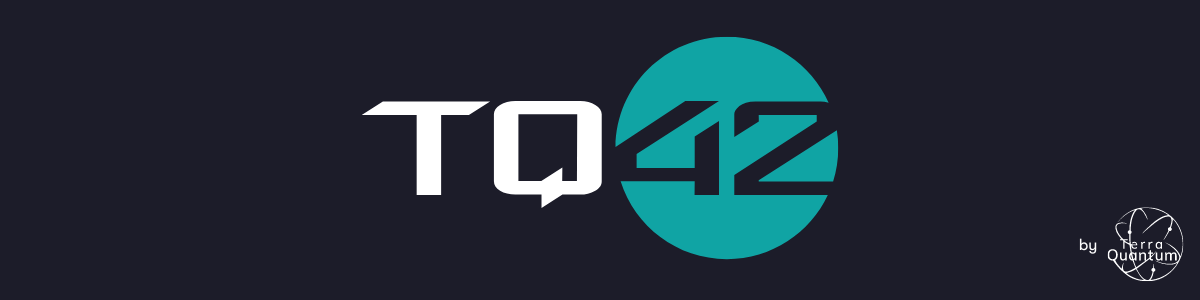

# Welcome to TQ42

## Example: Training a generic sequential machine learning model

## ✨ Introduction 
In this notebook, we will cover how to train a generic sequential machine learning model using the TQ42 SDK. For more details, please see the [developer documentation](https://docs.tq42.com/en/latest/index.html).

## 🎯 Objective

Building a generic sequential model involves:
1. Preparing and connecting a training dataset
2. Customizing the order and hyperparameters of various hybrid quantum neural net layers from our TQnet algorithm
3. Creating and monitoring an experiment run to train the model using the data


## 1. Import the TQ42 API

In [ ]:
#Import Packages
from tq42.client import TQ42Client
from tq42.organization import list_all as list_all_organizations
from tq42.project import list_all as list_all_projects
from tq42.experiment import list_all as list_all_experiments
from tq42.experiment_run import ExperimentRun
from tq42.compute import HardwareProto
from tq42.dataset import list_all
from tq42.dataset import Dataset

from tq42.algorithm import (
    TrainDataProcessingParametersProto,
    OptimProto, 
    LossFuncProto, 
    DatasetStorageInfoProto, 
    ActFuncProto,
    GenericMLTrainMetadataProto,
    GenericMLTrainParametersProto,
    Layer,
    PQNLayer,
    ClassicalDenseLayer,
    MLModelType,
    ActivationFunctionLayer,
    ActFuncProto,
    DropoutLayer,
    BatchNormalizationLayer,
    TrainModelInfoProto,
    MLTrainInputsProto,
    AlgorithmProto,
    MeasurementModeProto,
    MeasureProto,
    EntanglingProto,
    DiffMethodProto,
    QubitTypeProto,
    ClassicalLSTMLayer,
    QLSTMLayer,
)

from google.protobuf.json_format import MessageToDict

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 2. Create a client

In [ ]:
# Connect to the cloud service
# https://terraquantum.io
with TQ42Client() as client:
    client.login()

## 3. Select an organization, project and experiment

In [ ]:
# List the organizations available to you and select one

with TQ42Client() as client: 
    org_list = list_all_organizations(client=client)
    
org=None
def f(x):
    global org
    for o in org_list:
        if o.data.name == x:
            org = o
            print(f"Using organization {x}, {org.data.id}")
            return
        
interact(f, x=[o.data.name for o in org_list]);

In [ ]:
# List the projects within that organization and select one
   
with TQ42Client() as client: 
    proj_list = list_all_projects(client=client, organization_id=org.id)
    
proj=None
def f(x):
    global proj
    for p in proj_list:
        if p.data.name == x:
            proj = p
            print(f"Using project {x}, {proj.data.id}")
            return
        
interact(f, x=[p.data.name for p in proj_list]);

In [ ]:
# List the experiments within that project and select one

with TQ42Client() as client: 
    exp_list = list_all_experiments(client=client, project_id=proj.id)
    
exp=None
def f(x):
    global exp
    for e in exp_list:
        if e.data.name == x:
            exp = e
            print(f"Using experiment {x}, {exp.data.id}")
            return
        
interact(f, x=[e.data.name for e in exp_list]);

## 4. List Datasets Available in the Project 

In [ ]:
# List datasets in the project you can use to train your model
# You'll provide the id for one of these datasets along with the input and output columns when you train the model below. If you don't know the input/output columns for the dataset, it's best to upload a new one.

with TQ42Client() as client:
    datasets = list_all(client=client, project_id="ENTER_PROJECT_ID_HERE")
    print(datasets)

## 5. (Optional) Upload a Dataset

In [ ]:
# If you do not already have a dataset in that project, upload a dataset from a cloud storage bucket
# Note: The URL format is gs://[id_of_bucket].

from tq42.client import TQ42Client
from tq42.dataset import Dataset, DatasetSensitivityProto

with TQ42Client() as client:
    dataset = Dataset.create(
        client=client,
        name="<NAME_OF_THE_NEW_DATASET>",
        description="<DESCRIPTION_OF_THE_NEW_DATASET>",
        url="gs://<THIS_IS_YOUR_BUCKET_URL>",
        sensitivity=DatasetSensitivityProto.SENSITIVE,
        project_id="<PROJECT_ID>",
    )
    print(dataset.id)

## 6. Build and Train the Neural Network

### Classical Example

In [ ]:
print(f"Running experiment within: Org {org.data.name, org.id}, Proj {proj.data.name, proj.id} and Exp {exp.data.name, exp.id}`")

In [ ]:
# Build the classical neural network

classical_train_message=MessageToDict(GenericMLTrainMetadataProto(
    parameters=GenericMLTrainParametersProto(
        # Choose model type here
        model_type=MLModelType.MLP,
        # Add and customize and customize layers here
        layers=[
            Layer(classical_dense_layer=ClassicalDenseLayer(hidden_size=30, bias=True)),
            Layer(
                activation_function_layer=ActivationFunctionLayer(
                    function=ActFuncProto.RELU
                )
            ),
            Layer(classical_dense_layer=ClassicalDenseLayer(hidden_size=45, bias=True)),
            Layer(
                activation_function_layer=ActivationFunctionLayer(
                    function=ActFuncProto.RELU
                )
            ),
            Layer(classical_dense_layer=ClassicalDenseLayer(hidden_size=60, bias=True)),
            Layer(
                activation_function_layer=ActivationFunctionLayer(
                    function=ActFuncProto.SIGMOID
                )
            ),
            Layer(dropout_layer=DropoutLayer(value=0.5)),
            Layer(batch_normalization_layer=BatchNormalizationLayer()),
            Layer(
                classical_dense_layer=ClassicalDenseLayer(hidden_size=1, bias=False)
            ),  # Final layer, bias=False
        ],
        num_epochs=5,
        batch_size=128,
        learning_rate=0.05,
        k_fold=1,
        optim=OptimProto.ADAM,
        loss_func=LossFuncProto.MSE,
        train_model_info=TrainModelInfoProto(
            # Provide a unique name to identify your trained model
            name="ENTER_MODEL_NAME_HERE",
            # Add a brief description to help users understand the purpose or functionality of this trained model
            description="ADD_DESCRIPTION_HERE",
        ),
        # Specify the input and output columns for your dataset
        data_processing_parameters=TrainDataProcessingParametersProto(
            input_columns=[0, 1, 2, 3],
            output_columns=[4]
        )
    ),
    inputs=MLTrainInputsProto(
        # Provide the specific dataset storage ID of the data you uploaded to TQ42
        # storage_id=dataset_id here
        data=DatasetStorageInfoProto(storage_id="ENTER_DATASET_STORAGE_ID_HERE")
    ),
),preserving_proto_field_name=True)

In [ ]:
# Train the classical neural network

run = ExperimentRun.create(
    client=client,
    algorithm=AlgorithmProto.GENERIC_ML_TRAIN, 
    experiment_id=exp.id,
    compute=HardwareProto.SMALL, 
    parameters=classical_train_message
)

print(run.data)

In [ ]:
# Poll for the results

result = run.poll()
print(result.data)

### Export Results 

In [ ]:
# Export the trained dataset using the storage_id of the inferred_evaluation_data in the results above

dataset = Dataset(client=client, id="<YOUR_DATASET_ID>")
print(dataset)
exported_files = dataset.export(directory_path="<YOUR_EXPORT_PATH>")
print(exported_files)

### Hybrid Quantum Example

In [ ]:
# Build the hybrid quantum neural network

hybrid_quantum_train_message=MessageToDict(GenericMLTrainMetadataProto(
    parameters=GenericMLTrainParametersProto(
        # Choose model type here
        model_type=MLModelType.MLP,
        # Add and customize and customize layers here
        layers=[
            Layer(classical_dense_layer=ClassicalDenseLayer(hidden_size=4, bias=True)),
            Layer(
                activation_function_layer=ActivationFunctionLayer(
                    function=ActFuncProto.SIGMOID
                )
            ),
            Layer(classical_dense_layer=ClassicalDenseLayer(hidden_size=4, bias=True)),
            Layer(
                activation_function_layer=ActivationFunctionLayer(
                    function=ActFuncProto.SIGMOID
                )
            ),
            Layer(
                pqn_layer=PQNLayer(
                    num_qubits=4,
                    depth=7,
                    measurement_mode=MeasurementModeProto.NONE,
                    rotation=MeasureProto.X,
                    entangling=EntanglingProto.BASIC,
                    measure=MeasureProto.Z,
                    diff_method=DiffMethodProto.ADJOINT,
                    qubit_type=QubitTypeProto.LIGHTNING_QUBIT,
                )
            ),
            Layer(
                activation_function_layer=ActivationFunctionLayer(
                    function=ActFuncProto.SIGMOID
                )
            ),
            Layer(classical_dense_layer=ClassicalDenseLayer(hidden_size=1, bias=False)),
        ],
        num_epochs=5,
        k_fold=1,
        batch_size=128,
        learning_rate=0.05,
        optim=OptimProto.ADAM,
        loss_func=LossFuncProto.MSE,
        train_model_info=TrainModelInfoProto(
            # Provide a unique name to identify your trained model
            name="ENTER_MODEL_NAME_HERE",
            # Add a brief description to help users understand the purpose or functionality of this trained model
            description="ADD_DESCRIPTION_HERE",
        ),
        # Specify the input and output columns for your dataset
        data_processing_parameters=TrainDataProcessingParametersProto(
            input_columns=[0, 1, 2, 3],
            output_columns=[4]
        )
    ),
    inputs=MLTrainInputsProto(
        # Provide the specific dataset storage ID of the data you uploaded to TQ42.
        data=DatasetStorageInfoProto(storage_id="ENTER_DATASET_STORAGE_ID_HERE")
    ),
),preserving_proto_field_name=True)

In [ ]:
# Train the hybrid quantum neural network

run = ExperimentRun.create(
    client=client,
    algorithm=AlgorithmProto.GENERIC_ML_TRAIN, 
    experiment_id=exp.id,
    compute=HardwareProto.SMALL, 
    parameters=hybrid_quantum_train_message
)

print(run.data)

In [ ]:
# Poll for the results

result = run.poll()
print(result.data)

### Export Results

In [ ]:
# Export the trained dataset using the storage_id of the inferred_evaluation_data in the results above

dataset = Dataset(client=client, id="<YOUR_DATASET_ID>")
print(dataset)
exported_files = dataset.export(directory_path="<YOUR_EXPORT_PATH>")
print(exported_files)